In [1]:
from torchvision import transforms as T
from torchvision.datasets import ImageNet, ImageFolder
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from pathlib import Path

In [2]:
class LatentPrecomputeDataset(Dataset):
    def __init__(self, root):
        image_ds = ImageFolder(root)
        self.ds = image_ds.imgs
        self.transform = T.Compose([
            T.Resize(256),
            T.CenterCrop(256),
            T.ToTensor(),
            T.Lambda(lambda x: x * 2 - 1)
        ])
    
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        img_path, label = self.ds[idx]
        img = Image.open(img_path)
        img = self.transform(img)
        if img.shape[0] == 1:
            img = img.repeat(3, 1, 1)
        elif img.shape[0] == 4:
            img = img[:3]
        return {"img": img, "img_path": img_path, "label": label}

In [5]:
root = "/mnt/g//mnt/g/artbench-10-imagefolder-split/train"
ds = LatentPrecomputeDataset(root)
dl = DataLoader(ds, batch_size=64, num_workers=8)

In [6]:
from diffusers.models import AutoencoderKL
import torch


vae = AutoencoderKL.from_pretrained("stabilityai/sdxl-vae")
vae.cuda()
print("Model loaded")

Model loaded


In [7]:
from tqdm.auto import tqdm


for batch in tqdm(dl):
    img = batch["img"].cuda()
    img_path = batch["img_path"]
    label = batch["label"]
    
    with torch.autocast("cuda", dtype=torch.bfloat16):
        with torch.no_grad():
            latent = vae.encode(img).latent_dist.sample().mul_(0.13025)
    
    for i in range(len(img_path)):
        l = latent[i].cpu()
        save_path = img_path[i].replace("train", "latent_train")
        save_path = Path(save_path)
        save_path = save_path.parent / (save_path.stem + ".pth")
        if not save_path.parent.exists():
            save_path.parent.mkdir(parents=True)
        torch.save(l, save_path)

  0%|          | 0/782 [00:00<?, ?it/s]

100%|██████████| 782/782 [08:21<00:00,  1.56it/s]


torch.Size([1, 4, 32, 32])
torch.Size([1, 3, 256, 256])


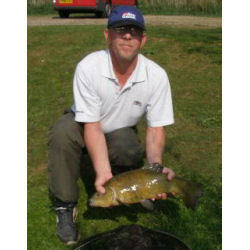

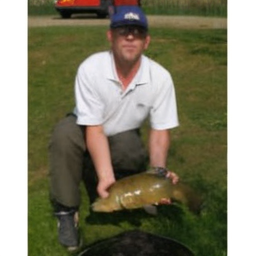

In [17]:
from torchvision.transforms.functional import to_pil_image

def unnormalize(x):
    x = x.clip(-1, 1)
    return (x + 1) / 2

l = torch.load("/mnt/g/ImageNet/latent_train/n01440764/n01440764_10026.pth")[None, :, :, :].cuda()

print(l.shape)
with torch.autocast("cuda", dtype=torch.bfloat16):
    with torch.no_grad():
        img = vae.decode(l / 0.13025).sample
        img = unnormalize(img)
print(img.shape)
display(Image.open("/mnt/g/ImageNet/train/n01440764/n01440764_10026.JPEG"))
display(to_pil_image(img[0].float()))